In [1]:
using Plots
using Flux
using DiffEqFlux
using OrdinaryDiffEq

In [4]:
t0 = 0.0
tend = 5.0
N = 200
true_x = range(t0, tend, length=N+1)
true_y = 2*exp.(-true_x./0.4) + randn(N+1)./(N+1)

201-element Vector{Float64}:
  1.9983739003972572
  1.8778984808259382
  1.767231843329263
  1.6558687770963796
  1.5490514450546924
  1.4614120873020697
  1.3789145624856436
  1.2899842070263503
  1.2091012521607603
  1.1347277455485065
  1.0642454883927521
  1.0045888455065275
  0.9394529929358398
  ⋮
  0.007383387838506652
 -0.004700689637661478
  0.0038909298882088736
  0.002268364942078632
  0.008070729505428698
 -0.004533478972323624
 -0.004451218727982368
 -0.002629414362805368
 -0.0034844205679866237
 -0.0006618349074613644
 -0.002182562778047444
  0.0038386967607466566

Loss: 0.3071808315690705
Loss: 0.2750780209385887
Loss: 0.25844916345631397
Loss: 0.1697387072026401
Loss: 0.15285865108554217
Loss: 0.17566682071111508
Loss: 0.1749596200631661
Loss: 0.14816052972398314
Loss: 0.1213552772977987
Loss: 0.10935233731592622
Loss: 0.10959764003138642
Loss: 0.11170225634343271
Loss: 0.10813704214328743
Loss: 0.09862963950141404
Loss: 0.0878507946266311
Loss: 0.08072864701671403
Loss: 0.079049481807564
Loss: 0.08071333704774866
Loss: 0.08174698047483707
Loss: 0.07957121180728022
Loss: 0.0746114948872704
Loss: 0.06920744116332317
Loss: 0.06543604064817567
Loss: 0.06371895696062914
Loss: 0.0629071892645888
Loss: 0.061395622937635674
Loss: 0.05828226296708239
Loss: 0.053812588717268864
Loss: 0.04902188607000453
Loss: 0.04499636318103858
Loss: 0.0422484825205641
Loss: 0.04050956605965067
Loss: 0.03899283061836741
Loss: 0.03694497093245896
Loss: 0.034136041282671725
Loss: 0.03096260576867918
Loss: 0.02811114305916578
Loss: 0.026052492257171312
Loss: 0.02474245371

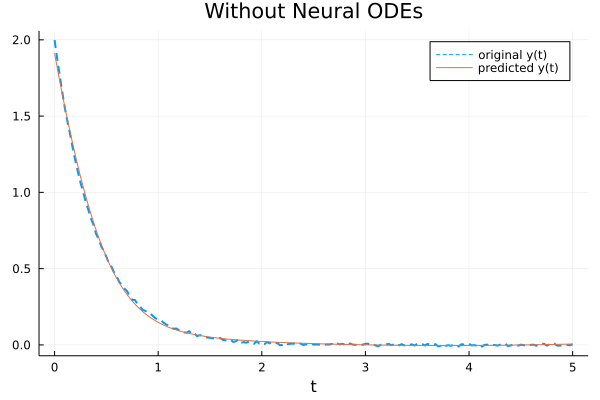

In [9]:
function neural_network(data_dim)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))
end

nn = neural_network(1)
theta = initial_params(nn)

predict(t, p) = nn(t', p)'

loss(p) = begin
  yhat = predict(true_x, p)
  l = Flux.mse(yhat, true_y)
end

learning_rate=1e-2
opt = ADAMW(learning_rate)
epochs = 200

function cb_train(theta, loss)
    println("Loss: ", loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

predicted_y = predict(true_x, res_train.minimizer)

plot(
    true_x,
    true_y,
    linewidth=2, ls=:dash,
    title="Without Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)

plot!(
    true_x,
    predicted_y,
    linewidth=1,
    label="predicted y(t)")

Loss: 3.555664542793308
Loss: 1.072604610546782
Loss: 0.45541212284480015
Loss: 0.2430844345260023
Loss: 0.15626167964803697
Loss: 0.11771982808459414
Loss: 0.10004130106471926
Loss: 0.0916351291493857
Loss: 0.08704015108120172
Loss: 0.08357487708489549
Loss: 0.07996139955613102
Loss: 0.07567091738895082
Loss: 0.07057912131351318
Loss: 0.06477364499990623
Loss: 0.0584431531522058
Loss: 0.05181315083788918
Loss: 0.04510917741106684
Loss: 0.03853648347986414
Loss: 0.03226973680781687
Loss: 0.026448677651123232
Loss: 0.021177399690532266
Loss: 0.016525705514616483
Loss: 0.012531671156748858
Loss: 0.009204868922950412
Loss: 0.006529958539360043
Loss: 0.0044705087962809975
Loss: 0.002972957758170184
Loss: 0.0019706802421141974
Loss: 0.0013881073746509517
Loss: 0.0011448244922607187
Loss: 0.0011595497141594182
Loss: 0.0013538466154130087
Loss: 0.0016554128136464252
Loss: 0.0020007930252655564
Loss: 0.0023373701015763746
Loss: 0.0026245578034545386
Loss: 0.002834155585536732
Loss: 0.002949916

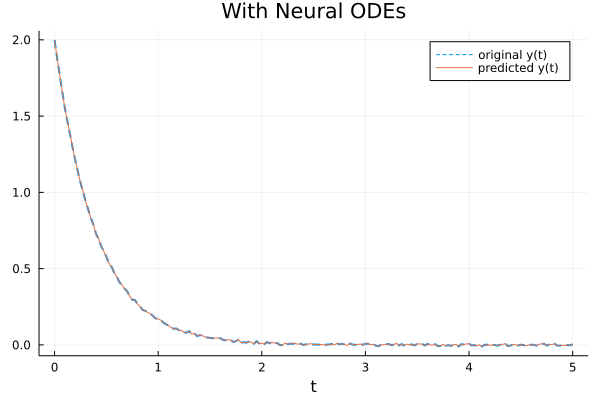

In [7]:
function neural_ode(data_dim; saveat = true_x)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))

    n_ode = NeuralODE(
            fc,
            (minimum(true_x), maximum(true_x)),
            Tsit5(),
            saveat = saveat,
            abstol = 1e-5, reltol = 1e-5)
end

n_ode = neural_ode(1)
theta = n_ode.p

predict(p) = n_ode(true_y[1:1], p)'

loss(p) = begin
  yhat = predict(p)
  l = Flux.mse(yhat, true_y)
end

learning_rate=1e-2
opt = ADAMW(learning_rate)
epochs = 50

function cb_train(theta, loss)
    println("Loss: ", loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

predicted_y = predict(res_train.minimizer)

plot(
    true_x,
    true_y,
    linewidth=2, ls=:dash,
    title="With Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)

plot!(
    true_x,
    true_y,
    linewidth=1,
    label="predicted y(t)")